In [1]:
import multiprocessing as mp
import parmap
import sys, os
import pandas as pd
import gzip

## List of inputs
# filelist_isec = ["/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_NA19443/0002.vcf", "/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_HG00109/0002.vcf"]
ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/OLD/BCFTOOLS_CLEAN/merge.vcf.gz", compression="gzip", sep="\t", names=["ID", "AC", "AF", "SAMPLE"])
# ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN_TAB/merge.txt.gz", compression="gzip", sep="\t")
# ref = pd.read_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge.parquet")
# ref = pd.read_csv(snakemake.input.ref, compression="gzip", sep="\t", nrows=10000)
ref

/g/korbel2/weber/miniconda3/envs/mosaicatcher_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ID,AC,AF,SAMPLE
0,1:54493:C:T,11,0.001718,HG00512
1,1:185275:G:C,13,0.002030,HG00512
2,1:190866:C:T,19,0.002967,HG00512
3,1:507289:T:G,25,0.003904,HG00512
4,1:666898:G:A,3,0.000468,HG00512
...,...,...,...,...
1332981,22:50764584:T:C,16,0.002498,NA19240
1332982,22:50767587:G:A,17,0.002655,NA19240
1332983,22:50777580:T:A,26,0.004060,NA19240
1332984,22:50800147:T:G,4,0.000625,NA19240


In [ ]:
ref.ID.nunique()

In [2]:
l = ["HG00268", "HG00512", "HG00514", "HG00731", "HG01352", "HG02059", "HG02818", "NA19239", "NA19240"]
ref_pool = ref.loc[ref["SAMPLE"].isin(l)]
# ref_pool.to_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge_lite.parquet")


In [ ]:
ref_pool.SAMPLE.unique()

In [3]:
m = mp.Manager()
l_df_gb = m.list()
l_df = m.list()

def mp_vcf(vcf, l_df_gb, l_df):

    # Nb of rows to skip at the beginning of the VCF
    skip = len([e.decode("ISO-8859–1").split('\n') for e in gzip.open("{}".format(f + vcf, "rb")) if e.decode("ISO-8859–1").split('\n')[0].startswith("##")])
    # chrom = vcf.split("/")[-3]
    sample = vcf.replace(".vcf.gz", "")
    df = pd.read_csv(f + vcf, compression="gzip", skiprows=skip, sep="\t")
    df["#CHROM"] = df["#CHROM"].astype(str)
    df["#CHROM"] = df["#CHROM"].str.replace("chr", "")
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str) + ":" + df["REF"] + ":" + df["ALT"]

    df = df.loc[df["QUAL"] >= 10]

    merge_df = pd.merge(ref, df, on="ID", how='right')

    merge_df["SAMPLE"] = merge_df["SAMPLE"].fillna("NAN")
    merge_df["QUERY_SAMPLE_CELL"] = sample
    

    merge_df_gb = merge_df.groupby("SAMPLE")["ID"].nunique().sort_values(ascending=False).reset_index()
    merge_df_gb["QUERY_SAMPLE_CELL"] = sample
    merge_df_gb["Rank"] = list(range(1,1+merge_df_gb.shape[0]))
    merge_df_gb["Total_SNP"] = df.shape[0]

    l_df_gb.append(merge_df_gb)
    l_df.append(merge_df)
f = "/scratch/tweber/DATA/1000G_SNV_with_GT/OLD/GENOTYPING/"
f_ldir = sorted([e for e in os.listdir(f) if e.endswith(".vcf.gz")])
parmap.starmap(mp_vcf, list(zip(f_ldir)), l_df_gb, l_df)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [16]:
pd.options.display.max_rows = 250
concat_df = pd.concat(list(l_df))
concat_df["QUERY_SAMPLE"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[0])
concat_df["QUERY_CELL"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[1])
# concat_df["FRACTION"] = concat_df["ID"] / concat_df["Total_SNP"]
# concat_df.sort_values(by="QUERY_SAMPLE_CELL")

concat_df

,ID,AC,AF,SAMPLE,#CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,pseudopool,QUERY_SAMPLE_CELL,QUERY_SAMPLE,QUERY_CELL
0,1:124041637:T:C,NaN,NaN,NAN,1,124041637,T,C,12.1518,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00504965:2:1,1:1:36:1:36",HG00268_438,HG00268,438
1,1:124041650:C:G,NaN,NaN,NAN,1,124041650,C,G,12.1518,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00504965:2:1,1:1:36:1:36",HG00268_438,HG00268,438
2,2:61023430:T:C,50.0,0.007808,NA19239,2,61023430,T,C,15.2010,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.0820108:2:1,1:1:21:1:36",HG00268_438,HG00268,438
3,4:49127337:T:A,NaN,NaN,NAN,4,49127337,T,A,10.3278,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00771993:2:1,1:1:36:1:25",HG00268_438,HG00268,438
4,7:155338259:A:G,NaN,NaN,NAN,7,155338259,A,G,24.8108,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00497648:2:1,1:1:14:1:36",HG00268_438,HG00268,438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,8:56588463:C:T,NaN,NaN,NAN,8,56588463,C,T,16.1171,.,AB=0.666667;ABP=3.73412;AC=1;AF=0.5;AN=2;AO=2;...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.92578:3:1,2:1:40:2:60",HG00731_086,HG00731,086
57,9:6979655:G:A,2.0,0.000312,HG00731,9,6979655,G,A,34.9392,.,AB=0.666667;ABP=3.73412;AC=1;AF=0.5;AN=2;AO=2;...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.98614:3:1,2:1:40:2:80",HG00731_086,HG00731,086
58,9:74346420:C:T,NaN,NaN,NAN,9,74346420,C,T,25.5033,.,AB=0.666667;ABP=3.73412;AC=1;AF=0.5;AN=2;AO=2;...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.97986:3:1,2:1:40:2:70",HG00731_086,HG00731,086
59,9:118129118:A:T,2.0,0.000312,HG00731,9,118129118,A,T,22.0271,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.0212707:2:1,1:1:15:1:37",HG00731_086,HG00731,086


In [23]:
concat_counts_df = concat_df.loc[concat_df["QUAL"] >= 10].groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df["QUERY_SAMPLE"] = concat_counts_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[0])
concat_counts_df = concat_counts_df.loc[concat_counts_df["SAMPLE"] != "NAN"]
concat_counts_df["Rank"] = concat_counts_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].transform(lambda r: range(1, len(r) + 1))
concat_counts_df.loc[concat_counts_df["QUERY_SAMPLE"] == concat_counts_df["SAMPLE"]]

,QUERY_SAMPLE_CELL,SAMPLE,Counts,QUERY_SAMPLE,Rank
7,HG00512_015,HG00512,26,HG00512,1
14,HG00512_017,HG00512,31,HG00512,1
20,HG00512_075,HG00512,30,HG00512,1
26,HG00512_081,HG00512,5,HG00512,1
31,HG00512_087,HG00512,6,HG00512,1
36,HG00512_092,HG00512,4,HG00512,1
41,HG00514_008,HG00514,1,HG00514,2
45,HG00514_015,HG00514,17,HG00514,1
49,HG00514_020,HG00514,21,HG00514,1
52,HG00514_023,HG00514,8,HG00514,1


In [17]:
merge_df = pd.merge(
    pd.merge(
            concat_df.groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 0").reset_index(),
            concat_df.loc[concat_df["QUAL"] >= 10].groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 10").reset_index(),
            on="QUERY_SAMPLE_CELL",how="outer"),
    concat_df.loc[(concat_df["QUAL"] >= 10) & (concat_df["QUERY_SAMPLE"]  == concat_df["SAMPLE"])].groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 10 FROM SAMPLE").reset_index(),
    on="QUERY_SAMPLE_CELL", how="outer"
).sort_values(by="QUERY_SAMPLE_CELL")
merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"] = merge_df["QUAL >= 10"].fillna(0) - merge_df["QUAL >= 10 FROM SAMPLE"].fillna(0)
merge_df["QUAL >= 10 FROM SAMPLE"] = merge_df["QUAL >= 10 FROM SAMPLE"].fillna(0)
merge_df["QUAL >= 10 FROM SAMPLE"] = merge_df["QUAL >= 10 FROM SAMPLE"].astype(int)
merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"] = merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"].astype(int)
merge_df


,QUERY_SAMPLE_CELL,QUAL >= 0,QUAL >= 10,QUAL >= 10 FROM SAMPLE,QUAL >= 10 FROM OTHER 3200 SAMPLES
0,HG00268_401,5,5,0,5
1,HG00268_402,4,4,0,4
2,HG00268_404,2,2,0,2
3,HG00268_438,5,5,0,5
4,HG00268_455,2,2,0,2
5,HG00512_015,125,125,26,99
6,HG00512_017,136,136,31,105
7,HG00512_075,160,160,30,130
8,HG00512_081,40,40,5,35
9,HG00512_087,52,52,6,46


In [15]:
merge_df = pd.merge(
    pd.merge(
            concat_df.groupby(["QUERY_SAMPLE_CELL", "SAMPLE"])["ID"].nunique().rename("QUAL >= 0").reset_index(),
            concat_df.loc[concat_df["QUAL"] >= 10].groupby(["QUERY_SAMPLE_CELL", "SAMPLE"])["ID"].nunique().rename("QUAL >= 10").reset_index(),
            on=["QUERY_SAMPLE_CELL", "SAMPLE"],how="outer"),
    concat_df.loc[(concat_df["QUAL"] >= 10) & (concat_df["QUERY_SAMPLE"]  == concat_df["SAMPLE"])].groupby(["QUERY_SAMPLE_CELL", "SAMPLE"])["ID"].nunique().rename("QUAL >= 10 FROM SAMPLE").reset_index(),
    on=["QUERY_SAMPLE_CELL", "SAMPLE"], how="outer"
).sort_values(by=["QUERY_SAMPLE_CELL", "SAMPLE"])
merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"] = merge_df["QUAL >= 10"].fillna(0) - merge_df["QUAL >= 10 FROM SAMPLE"].fillna(0)
merge_df["QUAL >= 10 FROM SAMPLE"] = merge_df["QUAL >= 10 FROM SAMPLE"].fillna(0)
merge_df["QUAL >= 10 FROM SAMPLE"] = merge_df["QUAL >= 10 FROM SAMPLE"].astype(int)
merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"] = merge_df["QUAL >= 10 FROM OTHER 3200 SAMPLES"].astype(int)
merge_df


KeyError: 'QUAL'

In [14]:
pd.options.display.max_rows = 250
concat_df = pd.concat(list(l_df_gb))
concat_df.sort_values(by=["QUERY_SAMPLE_CELL", "ID"], ascending=[True, False])
concat_df["QUERY_SAMPLE"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[0])
concat_df["QUERY_CELL"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[1])
concat_df = concat_df.loc[concat_df["QUERY_SAMPLE"] == concat_df["SAMPLE"]]
concat_df
# concat_df["FRACTION"] = concat_df["ID"] / concat_df["Total_SNP"]
# concat_df[["QUERY_SAMPLE_CELL", "Total_SNP"]].drop_duplicates().sort_values(by="QUERY_SAMPLE_CELL")

,SAMPLE,ID,QUERY_SAMPLE_CELL,Rank,Total_SNP,QUERY_SAMPLE,QUERY_CELL
1,HG02059,2,HG02059_337,2,11,HG02059,337
0,HG02059,1,HG02059_348,1,2,HG02059,348
1,HG01352,1,HG01352_442,2,3,HG01352,442
1,HG01352,1,HG01352_410,2,4,HG01352,410
1,HG02818,3,HG02818_308,2,14,HG02818,308
0,HG02818,7,HG02818_332,1,12,HG02818,332
0,HG02818,17,HG02818_312,1,28,HG02818,312
1,HG01352,1,HG01352_424,2,8,HG01352,424
1,HG02059,3,HG02059_326,2,13,HG02059,326
0,HG02059,1,HG02059_361,1,2,HG02059,361


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df.sort_values(by="QUERY_SAMPLE"), x="QUERY_SAMPLE", y="ID", hue="SAMPLE")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df.sort_values(by="QUERY_SAMPLE"), x="QUERY_SAMPLE", y="FRACTION", hue="SAMPLE")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df.loc[concat_df["QUERY_SAMPLE"] == concat_df["SAMPLE"]].sort_values(by="QUERY_SAMPLE"), x="QUERY_SAMPLE", y="FRACTION")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
norm = Normalize(0, 100)

sns.heatmap(data=merge_df.pivot_table(index="QUERY_SAMPLE_CELL", columns="SAMPLE", values="QUAL >= 0"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=norm)
plt.title("All SNPs - QUAL >= 0 - Genotyped from the complete 1kgp SNP file")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.heatmap(data=merge_df.pivot_table(index="QUERY_SAMPLE_CELL", columns="SAMPLE", values="QUAL >= 10"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=norm)
plt.title("All SNPs - QUAL >= 10 - Genotyped from the complete 1kgp SNP file")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.heatmap(data=concat_df.pivot_table(index="QUERY_SAMPLE_CELL", columns="SAMPLE", values="ID"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=LogNorm()    )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.heatmap(data=concat_df.pivot_table(index="QUERY_SAMPLE_CELL", columns="SAMPLE", values="ID"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=LogNorm()    )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.heatmap(data=concat_df.pivot_table(index="QUERY_SAMPLE_CELL", columns="SAMPLE", values="ID"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=LogNorm()    )

In [25]:
import multiprocessing as mp
import parmap
import sys, os
import pandas as pd
import gzip

## List of inputs
# filelist_isec = ["/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_NA19443/0002.vcf", "/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_HG00109/0002.vcf"]
# ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/OLD/BCFTOOLS_CLEAN/merge.vcf.gz", compression="gzip", sep="\t", names=["ID", "AC", "AF", "SAMPLE"])
ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/OTF/OTF/BCFTOOLS_CONCAT_TAB/merge.txt.gz", compression="gzip", sep="\t")
# ref = pd.read_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOO  LS_CLEAN/merge.parquet")
# ref = pd.read_csv(snakemake.input.ref, compression="gzip", sep="\t", nrows=10000)
ref

,ID,AC,AF,SAMPLE
0,10:18542:G:A,53,0.008276,NA10864
1,10:28524:C:T,106,0.016552,NA10864
2,10:36228:G:T,2,0.000312,NA10864
3,10:36229:G:A,2,0.000312,NA10864
4,10:47041:C:T,45,0.007027,NA10864
...,...,...,...,...
17317051,X:156022561:C:T,219,0.034197,HG04157
17317052,X:156028529:C:T,80,0.012492,HG04157
17317053,X:156028841:C:G,98,0.015303,HG04157
17317054,X:156028858:G:A,75,0.011711,HG04157


In [ ]:
ref.ID.nunique()

In [ ]:
l = ["HG00268", "HG00512", "HG00514", "HG00731", "HG01352", "HG02059", "HG02818", "NA19239", "NA19240"]
ref_pool = ref.loc[ref["SAMPLE"].isin(l)]
# ref_pool.to_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge_lite.parquet")


In [ ]:
ref.SAMPLE.unique()

In [ ]:
ref.SAMPLE.nunique()

In [26]:
m = mp.Manager()
l_df_gb = m.list()
l_df = m.list()

def mp_vcf(vcf, l_df_gb, l_df):

    # Nb of rows to skip at the beginning of the VCF
    skip = len([e.decode("ISO-8859–1").split('\n') for e in gzip.open("{}".format(f + vcf, "rb")) if e.decode("ISO-8859–1").split('\n')[0].startswith("##")])
    # chrom = vcf.split("/")[-3]
    sample = vcf.replace(".vcf.gz", "")
    df = pd.read_csv(f + vcf, compression="gzip", skiprows=skip, sep="\t")
    df["#CHROM"] = df["#CHROM"].astype(str)
    df["#CHROM"] = df["#CHROM"].str.replace("chr", "")
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str) + ":" + df["REF"] + ":" + df["ALT"]

    # df = df.loc[df["QUAL"] >= 10]

    merge_df = pd.merge(ref, df, on="ID", how='right')

    merge_df["SAMPLE"] = merge_df["SAMPLE"].fillna("NAN")
    merge_df["QUERY_SAMPLE_CELL"] = sample
    

    merge_df_gb = merge_df.groupby("SAMPLE")["ID"].nunique().sort_values(ascending=False).reset_index()
    merge_df_gb["QUERY_SAMPLE_CELL"] = sample
    merge_df_gb["Rank"] = list(range(1,1+merge_df_gb.shape[0]))
    merge_df_gb["Total_SNP"] = df.shape[0]

    l_df_gb.append(merge_df_gb)
    l_df.append(merge_df)
f = "/scratch/tweber/DATA/1000G_SNV_with_GT/OTF/GENOTYPING_OTF_POOL1/"
f_ldir = sorted([e for e in os.listdir(f) if e.endswith(".vcf.gz")])
parmap.starmap(mp_vcf, list(zip(f_ldir)), l_df_gb, l_df)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
pd.options.display.max_rows = 250
concat_df = pd.concat(list(l_df))
# concat_df["QUERY_SAMPLE"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[0])
# concat_df["QUERY_CELL"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[1])
# concat_df["FRACTION"] = concat_df["ID"] / concat_df["Total_SNP"]
# concat_df.sort_values(by="QUERY_SAMPLE_CELL")

concat_df

,ID,AC,AF,SAMPLE,#CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,HGSVCxPool1,QUERY_SAMPLE_CELL
0,10:38579559:T:C,58.0,0.009057,NA20510,10,38579559,T,C,12.0106,.,AB=0.25;ABP=5.18177;AC=1;AF=0.5;AN=2;AO=1;CIGA...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.000264327:4:3,1:3:108:1:36",HGSVCPool1x02PE20305
1,5:114882045:C:A,17.0,0.002655,NA19705,5,114882045,C,A,0.084942,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.016707:2:1,1:1:32:1:14",HGSVCPool1x02PE20305
2,5:114882045:C:A,17.0,0.002655,HG03098,5,114882045,C,A,0.084942,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.016707:2:1,1:1:32:1:14",HGSVCPool1x02PE20305
0,10:1368913:T:C,5.0,0.000781,NA20862,10,1368913,T,C,0.456728,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.0752093:2:1,1:1:36:1:36",HGSVCPool1x02PE20313
1,10:79139656:G:A,209.0,0.032636,HG01273,10,79139656,G,A,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2:122315157:C:T,119.0,0.018582,NA19474,2,122315157,C,T,2.16511,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.706748:2:1,1:1:36:1:32",HGSVCPool1x02PE20311
23,2:186780944:G:C,226.0,0.035290,NA19145,2,186780944,G,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20311
24,2:186780944:G:C,226.0,0.035290,HG01273,2,186780944,G,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20311
25,2:186780944:G:C,226.0,0.035290,HG02978,2,186780944,G,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20311


In [ ]:
ref.SAMPLE.nunique()

In [29]:
# concat_counts_df = concat_df.loc[concat_df["QUAL"] >= 10].groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df = concat_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df["Rank"] = concat_counts_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].transform(lambda r: range(1, len(r) + 1))
concat_counts_df

,QUERY_SAMPLE_CELL,SAMPLE,Counts,Rank
0,HGSVCPool1x02PE20302,NA19436,5,1
1,HGSVCPool1x02PE20302,HG04115,4,2
2,HGSVCPool1x02PE20302,HG02945,3,3
3,HGSVCPool1x02PE20302,HG00179,1,4
4,HGSVCPool1x02PE20302,HG01881,1,5
...,...,...,...,...
1213,HGSVCPool1x02PE20396,NA20869,7,37
1214,HGSVCPool1x02PE20396,HG02662,5,38
1215,HGSVCPool1x02PE20396,HG03771,5,39
1216,HGSVCPool1x02PE20396,HG04157,5,40


In [30]:
from io import StringIO

coverage_df = pd.read_csv(StringIO("""
    QUERY_SAMPLE_CELL   Average_Coverage
HGSVCPool1x02PE20301    8.17707E-05
HGSVCPool1x02PE20302    0.00572773
HGSVCPool1x02PE20303    0.00317793
HGSVCPool1x02PE20304    0.00189952
HGSVCPool1x02PE20305    0.00119985
HGSVCPool1x02PE20306    0.00131098
HGSVCPool1x02PE20307    0.00737752
HGSVCPool1x02PE20308    0.00141324
HGSVCPool1x02PE20309    0.0112285
HGSVCPool1x02PE20310    0.00456168
HGSVCPool1x02PE20311    0.00392759
HGSVCPool1x02PE20312    5.86631E-05
HGSVCPool1x02PE20313    0.00703299
HGSVCPool1x02PE20314    0.00503524
HGSVCPool1x02PE20315    0.00333497
HGSVCPool1x02PE20316    0.000519618
HGSVCPool1x02PE20317    0.000137767
HGSVCPool1x02PE20318    0.00548969
HGSVCPool1x02PE20319    0.00163587
HGSVCPool1x02PE20320    0.00418109
HGSVCPool1x02PE20321    0.00658923
HGSVCPool1x02PE20322    0.0027327
HGSVCPool1x02PE20323    0.00299357
HGSVCPool1x02PE20324    0.00890917
HGSVCPool1x02PE20325    0.00492877
HGSVCPool1x02PE20326    0.00143213
HGSVCPool1x02PE20327    0.00481344
HGSVCPool1x02PE20328    0.00388581
HGSVCPool1x02PE20329    0.00680642
HGSVCPool1x02PE20330    0.000154111
HGSVCPool1x02PE20331    0.00218126
HGSVCPool1x02PE20332    0.00859751
HGSVCPool1x02PE20333    0.00164514
HGSVCPool1x02PE20334    0.000703196
HGSVCPool1x02PE20335    0.00190209
HGSVCPool1x02PE20336    0.0038838
HGSVCPool1x02PE20337    0.00675901
HGSVCPool1x02PE20338    3.65387E-05
HGSVCPool1x02PE20339    0.000935516
HGSVCPool1x02PE20340    0.00257646
HGSVCPool1x02PE20341    0.00477984
HGSVCPool1x02PE20342    0.00652884
HGSVCPool1x02PE20343    8.13092E-05
HGSVCPool1x02PE20344    0.00356265
HGSVCPool1x02PE20345    0.00464779
HGSVCPool1x02PE20346    0.00682979
HGSVCPool1x02PE20347    0.000591239
HGSVCPool1x02PE20348    0.00370179
HGSVCPool1x02PE20349    0.00581684
HGSVCPool1x02PE20350    0.00236754
HGSVCPool1x02PE20351    0.00195363
HGSVCPool1x02PE20352    0.00667969
HGSVCPool1x02PE20353    0.00246195
HGSVCPool1x02PE20354    0.000146085
HGSVCPool1x02PE20355    0.00147454
HGSVCPool1x02PE20356    0.000255628
HGSVCPool1x02PE20357    0.0057233
HGSVCPool1x02PE20358    0.00579863
HGSVCPool1x02PE20359    0.00591062
HGSVCPool1x02PE20360    0.00279111
HGSVCPool1x02PE20361    0.006326
HGSVCPool1x02PE20362    0.00380982
HGSVCPool1x02PE20363    0.00505875
HGSVCPool1x02PE20364    0.00652577
HGSVCPool1x02PE20365    0.0110918
HGSVCPool1x02PE20366    0.0069164
HGSVCPool1x02PE20367    0.00759608
HGSVCPool1x02PE20368    0.00279501
HGSVCPool1x02PE20369    0.00742208
HGSVCPool1x02PE20370    0.00878356
HGSVCPool1x02PE20371    0.0005348
HGSVCPool1x02PE20372    0.000113975
HGSVCPool1x02PE20373    0.0106913
HGSVCPool1x02PE20374    0.00972966
HGSVCPool1x02PE20375    0.00674859
HGSVCPool1x02PE20376    0.000377218
HGSVCPool1x02PE20377    0.00403179
HGSVCPool1x02PE20378    0.00361018
HGSVCPool1x02PE20379    0.000126026
HGSVCPool1x02PE20380    0.0111083
HGSVCPool1x02PE20381    0.00401318
HGSVCPool1x02PE20382    0.00361074
HGSVCPool1x02PE20383    0.00949803
HGSVCPool1x02PE20384    0.00681164
HGSVCPool1x02PE20385    0.00406148
HGSVCPool1x02PE20386    0.00465365
HGSVCPool1x02PE20387    0.0119431
HGSVCPool1x02PE20388    0.0027732
HGSVCPool1x02PE20389    0.0106195
HGSVCPool1x02PE20390    0.0115936
HGSVCPool1x02PE20391    0.0106283
HGSVCPool1x02PE20392    0.00932004
HGSVCPool1x02PE20393    0.00541089
HGSVCPool1x02PE20394    0.0156839
HGSVCPool1x02PE20395    0.00392763
HGSVCPool1x02PE20396    0.0272284
    """), sep="   "
)
coverage_df

/tmp/ipykernel_77234/3895591768.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  coverage_df = pd.read_csv(StringIO("""


,QUERY_SAMPLE_CELL,Average_Coverage
0,HGSVCPool1x02PE20301,0.000082
1,HGSVCPool1x02PE20302,0.005728
2,HGSVCPool1x02PE20303,0.003178
3,HGSVCPool1x02PE20304,0.001900
4,HGSVCPool1x02PE20305,0.001200
5,HGSVCPool1x02PE20306,0.001311
6,HGSVCPool1x02PE20307,0.007378
7,HGSVCPool1x02PE20308,0.001413
8,HGSVCPool1x02PE20309,0.011229
9,HGSVCPool1x02PE20310,0.004562


In [31]:
ashleys_predictions = pd.read_csv("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/cell_selection/labels.tsv", sep="\t").rename({"cell": "QUERY_SAMPLE_CELL", "prediction" : "ashleys_prediction", "probability": "ashleys_probability"}, axis=1).sort_values(by="QUERY_SAMPLE_CELL")
ashleys_predictions["QUERY_SAMPLE_CELL"] = ashleys_predictions["QUERY_SAMPLE_CELL"].str.replace(".sort.mdup.bam", "")
mc_predictions = pd.read_csv("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/counts/HGSVCxPool1.info_raw", skiprows=13, sep="\t").rename({"cell": "QUERY_SAMPLE_CELL"}, axis=1)[["QUERY_SAMPLE_CELL", "mapped", "good", "pass1"]].rename({"mapped": "reads_mapped", "good" : "reads_used", "pass1": "mc_coverage_compliant"}, axis=1)
ashleys_mc_predictions = pd.merge(
    ashleys_predictions,
    mc_predictions,
    on="QUERY_SAMPLE_CELL"
)
ashleys_mc_predictions.loc[(ashleys_mc_predictions["ashleys_prediction"] == 1) & (ashleys_mc_predictions["mc_coverage_compliant"] == 1), "Used/Not used in MC"] = 1
ashleys_mc_predictions["Used/Not used in MC"] = ashleys_mc_predictions["Used/Not used in MC"].fillna(0)
ashleys_mc_predictions["Used/Not used in MC"] = ashleys_mc_predictions["Used/Not used in MC"].astype(int)
ashleys_mc_predictions

/tmp/ipykernel_77234/1901771676.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ashleys_predictions["QUERY_SAMPLE_CELL"] = ashleys_predictions["QUERY_SAMPLE_CELL"].str.replace(".sort.mdup.bam", "")


,QUERY_SAMPLE_CELL,ashleys_prediction,ashleys_probability,reads_mapped,reads_used,mc_coverage_compliant,Used/Not used in MC
0,HGSVCPool1x02PE20301,0,0.0000,6305,1400,0,0
1,HGSVCPool1x02PE20302,1,0.7984,1049263,93024,1,1
2,HGSVCPool1x02PE20303,0,0.0181,499590,49253,0,0
3,HGSVCPool1x02PE20304,0,0.0000,334000,33139,0,0
4,HGSVCPool1x02PE20305,0,0.0000,207771,19169,0,0
5,HGSVCPool1x02PE20306,0,0.0000,231964,23091,0,0
6,HGSVCPool1x02PE20307,1,0.7895,1427076,122780,1,1
7,HGSVCPool1x02PE20308,0,0.0000,243063,24729,0,0
8,HGSVCPool1x02PE20309,1,0.9334,1878930,178861,1,1
9,HGSVCPool1x02PE20310,0,0.1676,850784,76733,1,0


In [33]:
merge_df = pd.merge(
        concat_df.groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 0").reset_index(),
        concat_df.loc[concat_df["QUAL"] >= 10].groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 10").reset_index(),
        on="QUERY_SAMPLE_CELL",how="outer").sort_values(by="QUERY_SAMPLE_CELL")

import numpy as np
vcf_list = list(concat_df.QUERY_SAMPLE_CELL.unique())
empty_samples_list = [{"QUERY_SAMPLE_CELL" : "HGSVCPool1x02PE20{}".format(str(e)), "QUAL >= 0" : np.nan, "QUAL >= 10" : np.nan, } for e in list(range(301, 397)) if "HGSVCPool1x02PE20{}".format(str(e)) not in vcf_list]

merge_df = pd.concat([merge_df, pd.DataFrame(empty_samples_list)]).sort_values(by="QUERY_SAMPLE_CELL")
merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"], values=["SAMPLE"], aggfunc=lambda x: ' '.join(x)),
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"]),
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        coverage_df,
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        ashleys_mc_predictions,
        on="QUERY_SAMPLE_CELL",
        how="left"
)

merge_df.columns = ['QUERY_SAMPLE_CELL', 'QUAL>=0', 'QUAL>=10', 'SAMPLE_1', 'SAMPLE_2', 'SAMPLE_3', 'Counts_1', 'Counts_2', 'Counts_3', 'Average_Coverage', 'ashleys_prediction', 'ashleys_probability', 'reads_mapped', 'reads_used', 'mc_coverage_compliant', 'Used/Not used in MC']

# merge_df.to_excel("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/config/stats_pooling.xlsx", index=False)

# import os, sys, stat
# os.chmod("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/config/stats_pooling.xlsx", stat.S_IRWXG)

merge_df[["QUERY_SAMPLE_CELL", "SAMPLE_1", "SAMPLE_2", "SAMPLE_3", "Counts_1", "Counts_2", "Counts_3"]]


/tmp/ipykernel_77234/1316767160.py:11: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(
/tmp/ipykernel_77234/1316767160.py:17: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(


,QUERY_SAMPLE_CELL,SAMPLE_1,SAMPLE_2,SAMPLE_3,Counts_1,Counts_2,Counts_3
0,HGSVCPool1x02PE20301,NaN,NaN,NaN,NaN,NaN,NaN
1,HGSVCPool1x02PE20302,NA19436,HG04115,HG02945,5.0,4.0,3.0
2,HGSVCPool1x02PE20303,HG01881,HG01916,HG04115,2.0,1.0,1.0
3,HGSVCPool1x02PE20304,HG00097,HG01881,HG03771,1.0,1.0,1.0
4,HGSVCPool1x02PE20305,HG03098,NA19705,NA20510,1.0,1.0,1.0
5,HGSVCPool1x02PE20306,HG00179,NaN,NaN,1.0,NaN,NaN
6,HGSVCPool1x02PE20307,HG01273,NA19436,HG01881,10.0,5.0,4.0
7,HGSVCPool1x02PE20308,HG01881,HG01916,HG02972,1.0,1.0,1.0
8,HGSVCPool1x02PE20309,NA18965,NA19145,HG01916,15.0,4.0,3.0
9,HGSVCPool1x02PE20310,HG01273,HG02972,NA20510,4.0,3.0,2.0


In [129]:
merge_df[['ashleys_prediction', 'mc_coverage_compliant', 'Used/Not used in MC']].sum()

ashleys_prediction       30
mc_coverage_compliant    58
Used/Not used in MC      30
dtype: int64

[Text(0, 0, 'HG00097'),
 Text(1, 0, 'HG00179'),
 Text(2, 0, 'HG00766'),
 Text(3, 0, 'HG01273'),
 Text(4, 0, 'HG01881'),
 Text(5, 0, 'HG01916'),
 Text(6, 0, 'HG01978'),
 Text(7, 0, 'HG02615'),
 Text(8, 0, 'HG02662'),
 Text(9, 0, 'HG03480'),
 Text(10, 0, 'NA18537'),
 Text(11, 0, 'NA18965'),
 Text(12, 0, 'NA19202'),
 Text(13, 0, 'NA19436'),
 Text(14, 0, 'NA19474')]

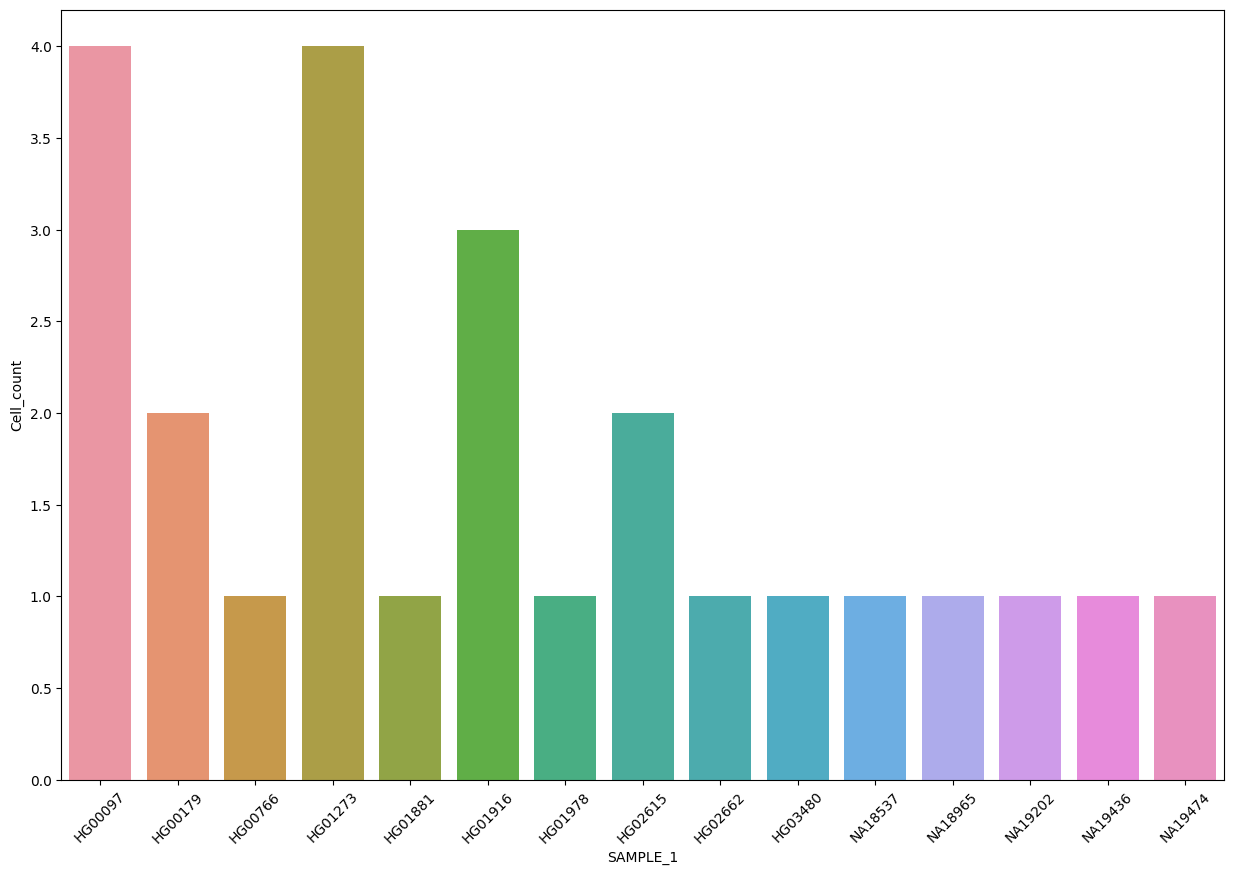

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))


merge_df

ax = sns.barplot(data=merge_df.loc[merge_df["Used/Not used in MC"] == 1].groupby("SAMPLE_1")["QUERY_SAMPLE_CELL"].nunique().rename("Cell_count").reset_index(),  x="SAMPLE_1", y="Cell_count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
merge_df.columns